In [1]:
# Initialization
from math import * 
import base64
import re
import json 
import numpy as np
import matplotlib as mp
import random as rand
import matplotlib.pyplot as plt
import timeit
from collections import namedtuple 

# Am I working on AWS?
AWS = False

# Check Spark is working
print sc 

In [2]:
%matplotlib inline

### 2. PCA on scanned digits

In [3]:
if AWS:
    rawData = "s3n://stat-37601/digits.base64.json"
else:
    rawData = "data/digits.base64.json"

# Turns the data into a numpy array
def parse(x):
    digit = json.loads(x)
    array = np.fromstring(base64.b64decode(digit["data"]),dtype=np.ubyte)
    return [(np.array([digit["label"]]), array)]

# Gather all the color vectors into one matrix and get list of labels
# I found that this is much quicker than using a reduce statement to join the vectors into a matrix
imageData =sc.textFile(rawData).map(parse).reduce(lambda x,y: x+y)
imgMatrix =      np.vstack([img[1] for img in imageData])
labels    = np.concatenate([img[0] for img in imageData])

#### (a) Standardize data and extract PCA

In [4]:
# Rows are images, columns are pixels
images,pixels = imgMatrix.shape

# Standardize. Since some cells have low standard deviation, I winsorize
pixMeans = np.mean(imgMatrix,axis=0)
pixSDs   = np.max(np.vstack((np.std(imgMatrix,axis=0),np.ones(pixels)/100)),axis=0) # When SD=0, set it to .01 so we don't divide by 0

# Remove the mean
standMatrix = imgMatrix-pixMeans

# When I'm running this on my home computer, I run out of memory trying to do SVD
if AWS:
    U, s, V = np.linalg.svd(standMatrix.T)
else:
    lam, V = np.linalg.eig(np.dot(standMatrix.T,standMatrix))
    # Don't necessarily come out sorted
    order = np.argsort(lam)
    s = lam[order[::-1]]
    V = V[:,order[::-1]]

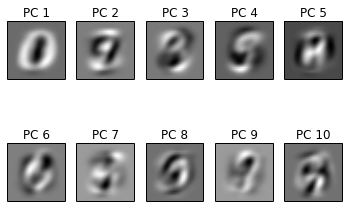

In [5]:
# Show the first 10 PCs
f,subplts = plt.subplots(2,5)
vectors = V[:,0:10].astype(float)/256
for i in range(0,10):
    r = i/5
    c = i%5
    subplts[r,c].imshow(vectors[:,i].reshape(28,28)).set_cmap('gray_r')
    subplts[r,c].axes.get_xaxis().set_visible(False)
    subplts[r,c].get_yaxis().set_visible(False)
    subplts[r,c].set_title('PC ' + str(i+1))



#### (b) Plot the variance of the principal components (the singular values)

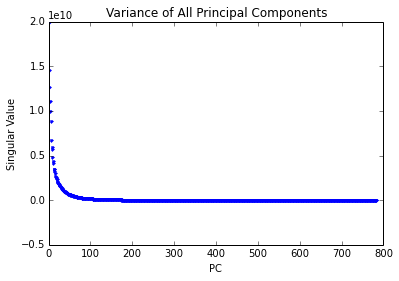

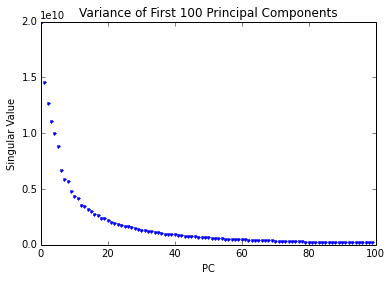

In [7]:
plt.plot(s,'.')
plt.title('Variance of All Principal Components');
plt.xlabel('PC')
plt.ylabel('Singular Value')
plt.show()

n= 100
plt.plot(s[0:n],'.')
plt.title('Variance of First ' + str(n) + ' Principal Components');
plt.xlabel('PC')
plt.ylabel('Singular Value')
plt.show()

#### (c) Represent images with the first m principal components

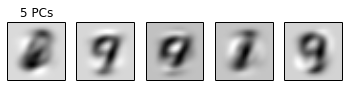

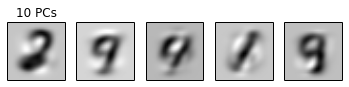

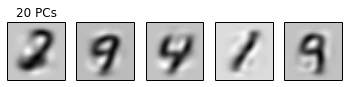

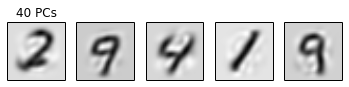

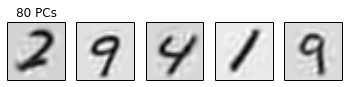

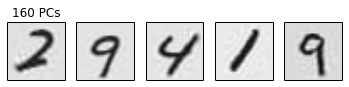

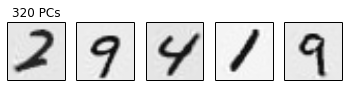

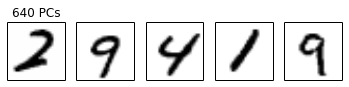

In [10]:
# Pick number of PCs to try, and a few test images
mVals = [5,10,20,40,80,160,320,640]
dataPoints = rand.sample(range(0,images),5)

# Rotate test images to represent in PC basis
rotatedDataPoints = np.dot(standMatrix[dataPoints,:],V)

for i_,m in enumerate(mVals):
    # Get the representation of the points in the original space based on m PCs
    repreMatrix = np.dot(rotatedDataPoints[:,0:m],V[:,0:m].T)+pixMeans
    
    # Set up the main plot with 2x5 subplots
    f,subplts = plt.subplots(1, len(dataPoints))
    vectors = repreMatrix.astype(float)/256
    subplts[0].set_title(str(m) + ' PCs')
    for j_,d in enumerate(dataPoints):
        subplts[j_].imshow(vectors[j_,:].reshape(28,28)).set_cmap('gray_r')
        subplts[j_].axes.get_xaxis().set_visible(False)
        subplts[j_].get_yaxis().set_visible(False)
        

#### (d) Plot reconstruction error

We can get the reconstruction error from the eigen values.

Proof:
Let the first $m$ principal components form the matrix $V_1$. The remaining $d-m$ components will form $V_2$. Thus, the reconstruction residual when using the first $m$ components is:
$$X-XV_1V_1' = X[V_1 V_2][V_1 V_2]' - XV_1V_1' = XV_1V_1' +XV_2V_2' - XV_1V_1' = XV_2V_2'$$
Thus, the reconstruction error, where S is the diagonal matrix of the eigen vectors corresponding to $V_2$:
\begin{align}
tr(V_2V_2'X'XV_2V_2') &= tr(V_2'V_2V_2'X'XV_2) \\
&= tr(V_2'X'XV_2)  \\
&= tr(V_2'SV_2) \\
&= tr(diag(\lambda_{m+1},...,\lambda_d) \\
&= \sum_{i=m+1}^d \lambda_d
\end{align}

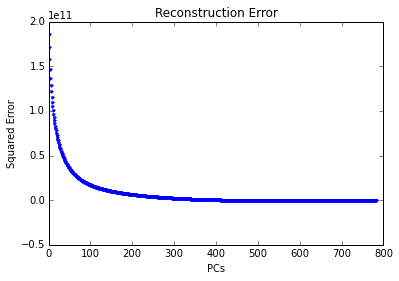

In [13]:
# Full PC representation of all data points
#rotatedMatrix = np.dot(standMatrix,V)

# Now, the reconstruction error is just the sum of the singular values corresponding to the unused PCs
reconError = np.sum(s) - np.cumsum(s)

plt.plot(range(0,pixels),reconError,'.')
plt.title('Reconstruction Error')
plt.xlabel('PCs')
plt.ylabel('Squared Error')
plt.show()